<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Bubble Plots**


Estimated time needed: **30** minutes


In this lab, you will focus on visualizing data.

The dataset will be directly loaded into pandas for analysis and visualization.

You will use various visualization techniques to explore the data and uncover key trends.


## Objectives


In this lab, you will perform the following:


-   Visualize the distribution of data.

-   Visualize the relationship between two data features.

-   Visualize composition of data.

-   Visualize comparison of data.


#### Setup: Working with the Database
**Install and import the needed libraries**


In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import requests
from tqdm.notebook import tqdm
from urllib.parse import urlparse
import sqlite3

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Connect to the SQLite database
conn = sqlite3.connect('survey-results-public.sqlite')

**Download and connect to the database file containing survey data.**


To start, download and load the dataset into a `pandas` DataFrame.



In [2]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv"

file_name = urlparse(file_path).path.strip('/').split('/')[-1]

In [3]:
# Load the Stack Overflow survey dataset
df = pd.read_csv(file_name)

# Display the first few rows of the dataset
df.head(3)

ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   

                                           EdLevel  \
0                        Primary/elementary school   
1     Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
2  Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   

                                           LearnCode  \
0                             Books / Physical media   
1  Books / Physical media;Colleague;On the job tr...   
2  Books / Physical media;Colleague;On the job tr...   

                                     LearnCodeOnline  \
0                                                NaN   
1  Technical documentation;Blogs;Books;Written Tu...   
2  Technical documentation;Blogs;Books;Written Tu...   

                                             TechDoc YearsCode YearsCodePro  \
0                                                NaN       NaN          NaN   
1  API document(s) and/or SDK document(s);User gu...        20           17   
2  API document(s) and/or SDK document(s);User gu...        37           27   

                 DevType OrgSize PurchaseInfluence BuyNewTool BuildvsBuy  \
0                    NaN     NaN               NaN        NaN        NaN   
1  Developer, full-stack     NaN               NaN        NaN        NaN   
2   Developer Experience     NaN               NaN        NaN        NaN   

  TechEndorse                                            Country Currency  \
0         NaN                           United States of America      NaN   
1         NaN  United Kingdom of Great Britain and Northern I...      NaN   
2         NaN  United Kingdom of Great Britain and Northern I...      NaN   

   CompTotal                             LanguageHaveWorkedWith  \
0        NaN                                                NaN   
1        NaN  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2        NaN                                                 C#   

                              LanguageWantToWorkWith  \
0                                                NaN   
1  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2                                                 C#   

                                     LanguageAdmired  \
0                                                NaN   
1  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...   
2                                                 C#   

        DatabaseHaveWorkedWith      DatabaseWantToWorkWith  \
0                          NaN                         NaN   
1  Dynamodb;MongoDB;PostgreSQL                  PostgreSQL   
2   Firebase Realtime Database  Firebase Realtime Database   

              DatabaseAdmired                    PlatformHaveWorkedWith  \
0                         NaN                                       NaN   
1                  PostgreSQL  Amazon Web Services (AWS);Heroku;Netlify   
2  Firebase Realtime Database                              Google Cloud   

                     PlatformWantToWorkWith  \
0                                       NaN   
1  Amazon Web Services (AWS);Heroku;Netlify   
2                              Google Cloud   

                            PlatformAdmired         WebframeHaveWorkedWith  \
0                                       NaN                            NaN   
1  Amazon Web Services (AWS);Heroku;Netlify  Express;Next.js;Node.js;React   
2                             

### Task 1: Exploring Data Distributions Using Bubble Plots


#### 1. Bubble Plot for Age vs. Frequency of Participation


- Visualize the relationship between respondents’ age and their participation frequency (`SOPartFreq`) using a bubble plot.

- Use the size of the bubbles to represent their job satisfaction (`JobSat`).


In [4]:
age_freq_sat = df.copy().loc[:,["Age", "SOPartFreq", "JobSat"]].dropna()

# Define mappings for Age and SOPartFreq
age_mapping = {
    "Under 18 years old": 17,
    "18-24 years old": 21,
    "25-34 years old": 29.5,
    "35-44 years old": 39.5,
    "45-54 years old": 49.5,
    "55-64 years old": 59.5,
    "65 years or older": 70
}

so_part_freq_mapping = {
    "I have never participated in Q&A on Stack Overflow": 0,
    "Less than once per month or monthly": 1,
    "A few times per month or weekly": 2,
    "A few times per week": 3,
    "Daily or almost daily": 4,
    "Multiple times per day": 5
}


# Apply mappings
age_freq_sat["AgeNumeric"] = age_freq_sat["Age"].map(age_mapping)
age_freq_sat["SOPartFreqNumeric"] = age_freq_sat["SOPartFreq"].map(so_part_freq_mapping)
# age_freq_sat["JobSat"] = age_freq_sat["JobSat"] * 5

# Ensure JobSat is numeric
age_freq_sat["JobSat"] = pd.to_numeric(age_freq_sat["JobSat"], errors="coerce")

# Aggregate by age
age_freq_sat_grouped = age_freq_sat.groupby("AgeNumeric").agg(
    {"SOPartFreqNumeric": "mean", "JobSat": "mean"}
).reset_index()

age_freq_sat_grouped

AgeNumeric  SOPartFreqNumeric  JobSat
0       17.00               1.15    7.25
1       21.00               0.93    6.75
2       29.50               1.10    6.90
3       39.50               1.26    7.05
4       49.50               1.36    7.17
5       59.50               1.44    7.29
6       70.00               1.45    7.99

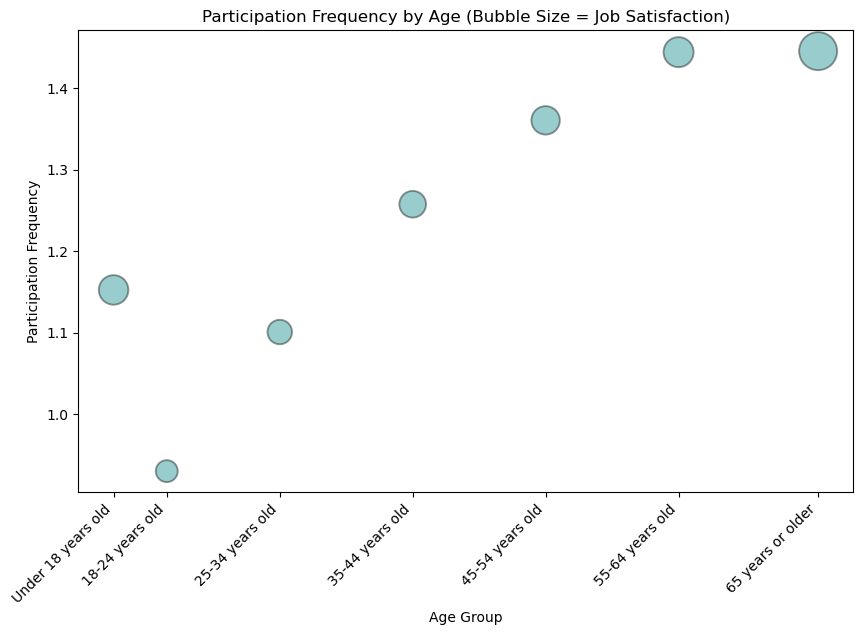

In [5]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=age_freq_sat_grouped, x="AgeNumeric", y="SOPartFreqNumeric", size="JobSat", sizes=(250,750), alpha=0.4, legend=False, color='teal', edgecolors='black')
plt.title("Participation Frequency by Age (Bubble Size = Job Satisfaction)")
plt.xlabel("Age Group")
plt.xticks(age_freq_sat_grouped["AgeNumeric"], labels=age_mapping.keys(), rotation=45, ha='right')
# plt.yticks(age_freq_sat_grouped["SOPartFreqNumeric"], labels=so_part_freq_mapping.keys(), rotation=45, ha='right')
plt.ylabel("Participation Frequency")

plt.savefig("Lab 20 Plots/Task 1-1 Participation Frequency by Age")
plt.show()

#### 2. Bubble Plot for Compensation vs. Job Satisfaction


- Visualize the relationship between yearly compensation (`ConvertedCompYearly`) and job satisfaction (`JobSat`).

- Use the size of the bubbles to represent respondents’ age.


In [6]:
comp_sat_age = df.copy().loc[:,["ConvertedCompYearly", "JobSat", "Age"]].dropna()

comp_sat_age["AgeNumeric"] = comp_sat_age["Age"].map(age_mapping)

# Aggregate by age
comp_sat_age_grouped = comp_sat_age.groupby("AgeNumeric").agg(
    {"ConvertedCompYearly": "median", "JobSat": "mean"}
).reset_index()
comp_sat_age_grouped

AgeNumeric  ConvertedCompYearly  JobSat
0       17.00             8,661.00    7.11
1       21.00            25,443.00    6.70
2       29.50            60,000.00    6.85
3       39.50            85,905.50    7.01
4       49.50           101,770.00    7.08
5       59.50           118,263.00    7.43
6       70.00           121,668.00    7.78

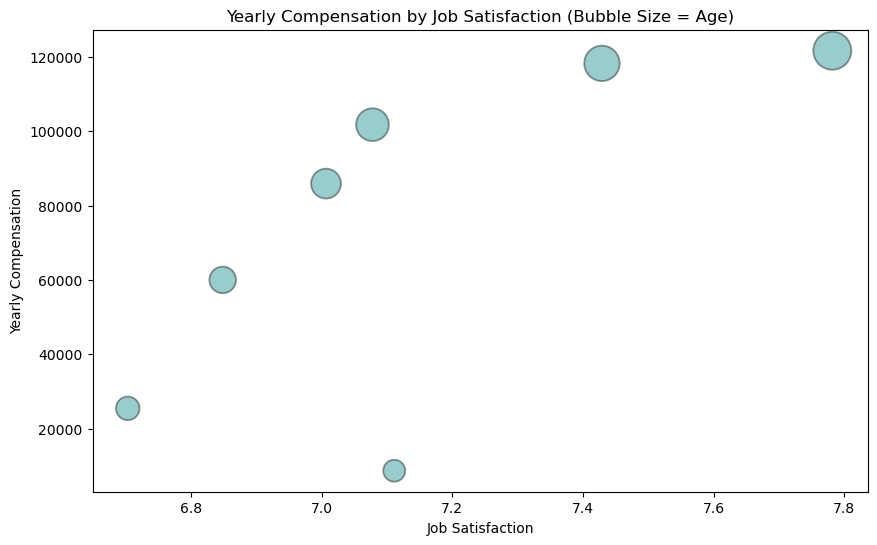

In [7]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=comp_sat_age_grouped, x="JobSat", y="ConvertedCompYearly", size="AgeNumeric", sizes=(250,750), alpha=0.4, legend=False, color='teal', edgecolors='black')
plt.title("Yearly Compensation by Job Satisfaction (Bubble Size = Age)")
plt.xlabel("Job Satisfaction")
plt.ylabel("Yearly Compensation")

plt.savefig("Lab 20 Plots/Task 1-2 Yearly Compensation by Job Satisfaction")
plt.show()

### Task 2: Analyzing Relationships Using Bubble Plots


#### 1. Bubble Plot of Technology Preferences by Age

- Visualize the popularity of programming languages respondents have worked with (`LanguageHaveWorkedWith`) across age groups.

- Use bubble size to represent the frequency of each language.



In [8]:
tech_age = df.copy().loc[:,["LanguageHaveWorkedWith", "Age"]].dropna()

tech_age["AgeNumeric"] = tech_age["Age"].map(age_mapping)
tech_age["LanguageHaveWorkedWith"] = tech_age["LanguageHaveWorkedWith"].str.split(";")

tech_age = tech_age.explode("LanguageHaveWorkedWith")

tech_age_group = tech_age.groupby(['AgeNumeric', 'LanguageHaveWorkedWith']).size().reset_index(name='Frequency')
tech_age_group["Frequency"] = tech_age_group["Frequency"] * 10
tech_age_group

AgeNumeric   LanguageHaveWorkedWith  Frequency
0         17.00                      Ada        250
1         17.00                     Apex         70
2         17.00                 Assembly       2420
3         17.00  Bash/Shell (all shells)       7460
4         17.00                        C       7460
5         17.00                       C#       6500
6         17.00                      C++       9020
7         17.00                  Clojure        130
8         17.00                    Cobol         80
9         17.00                  Crystal         90
10        17.00                     Dart       1550
11        17.00                   Delphi        180
12        17.00                   Elixir        220
13        17.00                   Erlang         90
14        17.00                       F#        120
15        17.00                  Fortran        150
16        17.00                 GDScript       2140
17        17.00                       Go       2760
18        17.00                   Groovy        240
19        17.00                 HTML/CSS      15600
20        17.00                  Haskell        610
21        17.00                     Java       8170
22        17.00               JavaScript      15380
23        17.00                    Julia        210
24        17.00                   Kotlin       2300
25        17.00                     Lisp        260
26        17.00                      Lua       3790
27        17.00                   MATLAB        250
28        17.00              MicroPython       1470
29        17.00                      Nim        160
30        17.00                    OCaml        180
31        17.00              Objective-C        200
32        17.00                      PHP       3040
33        17.00                     Perl        250
34        17.00               PowerShell       3010
35        17.00                   Prolog         50
36        17.00                   Python      16560
37        17.00                        R        380
38        17.00                     Ruby        750
39        17.00                     Rust       5380
40        17.00                      SQL       6560
41        17.00                    Scala        140
42        17.00                 Solidity        160
43        17.00                    Swift       1030
44        17.00               TypeScript       7180
45        17.00                      VBA        440
46        17.00      Visual Basic (.Net)        770
47        17.00                   Zephyr         20
48        17.00                      Zig        760
49        21.00                      Ada       1170
50        21.00                     Apex        710
51        21.00                 Assembly      13050
52        21.00  Bash/Shell (all shells)      40690
53        21.00                        C      43090
54        21.00                       C#      34420
55        21.00                      C++      45430
56        21.00                  Clojure       1070
57        21.00                    Cobol        530
58        21.00                  Crystal        380
59        21.00                     Dart      12400
60        21.00                   Delphi        760
61        21.00                   Elixir       1470
62        21.00                   Erlang        690
63        21.00                       F#        860
64        21.00                  Fortran        820
65        21.00                 GDScript       4590
66        21.00                       Go      18270
67        21.00                   Groovy       2350
68        21.00                 HTML/CSS      77240
69        21.00                  Haskell       5410
70        21.00                     Java      50380
71        21.00               JavaScript      85180
72        21.00                    Julia       1760
73        21.00                   Kotlin      14560
74        21.00                     Lisp       2130
75        21.00                      Lua      11490
7

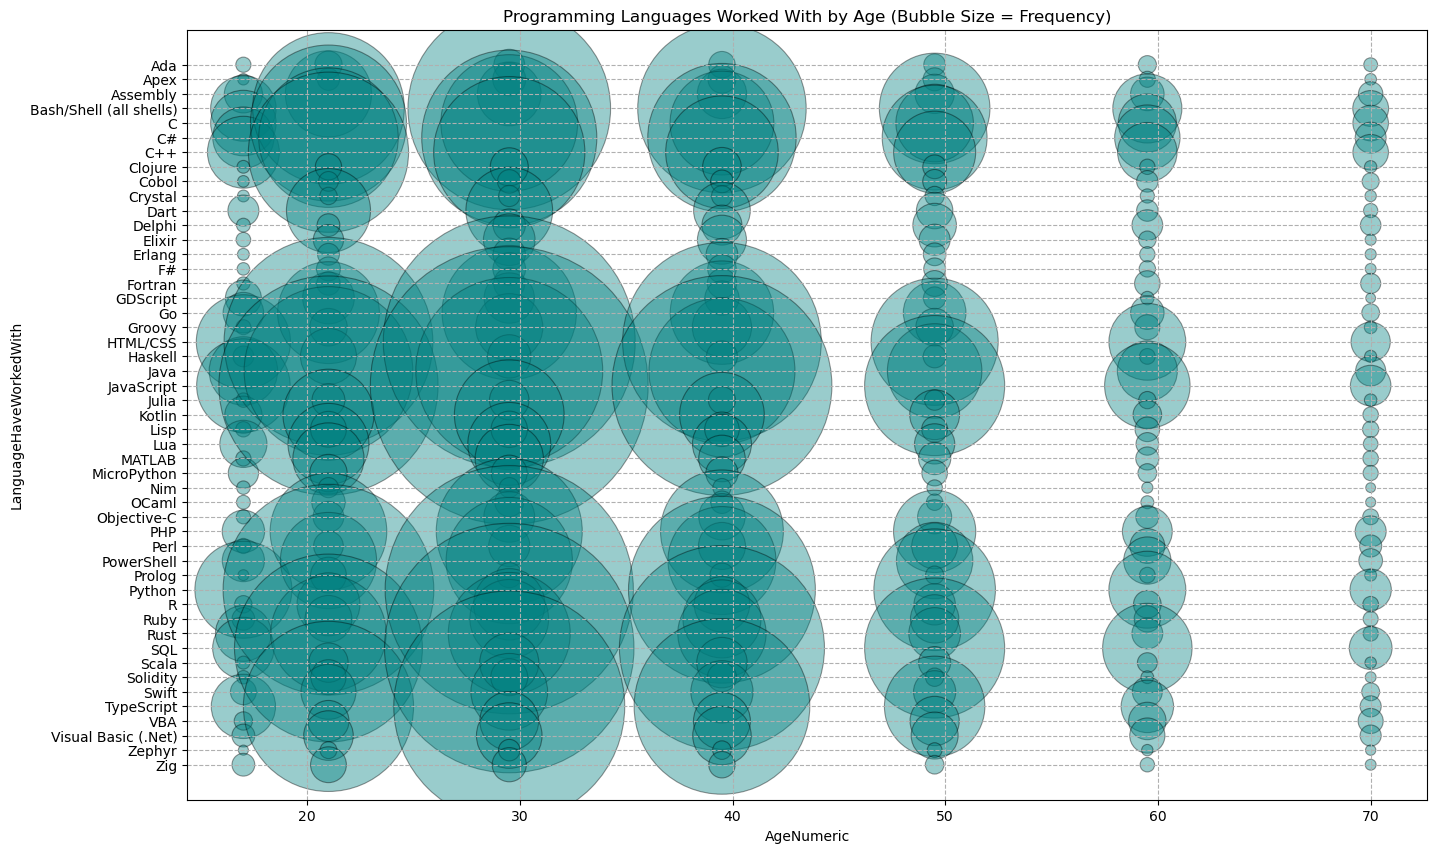

In [9]:
plt.figure(figsize=(16,10))
sns.scatterplot(data=tech_age_group, x="AgeNumeric", y="LanguageHaveWorkedWith", size="Frequency", sizes=(50, 40000), alpha=0.4, legend=False, color='teal', edgecolors='black')
# plt.scatter(data=tech_age_group, x="AgeNumeric", y="LanguageHaveWorkedWith", s="Frequency", alpha=0.4, color='teal', edgecolors='black')
plt.title("Programming Languages Worked With by Age (Bubble Size = Frequency)")
plt.xlabel("AgeNumeric")
plt.ylabel("LanguageHaveWorkedWith")
plt.grid(True, linestyle='--')

plt.savefig("Lab 20 Plots/Task 2-1 Programming Languages Worked With by Age")
plt.show()

#### 2. Bubble Plot for Preferred Databases vs. Job Satisfaction

- Explore the relationship between preferred databases (`DatabaseWantToWorkWith`) and job satisfaction.

- Use bubble size to indicate the number of respondents for each database.


In [10]:
db_sat = df.copy().loc[:,["DatabaseWantToWorkWith", "JobSat"]].dropna()

db_sat["DatabaseWantToWorkWith"] = db_sat["DatabaseWantToWorkWith"].str.split(";")
db_sat = db_sat.explode("DatabaseWantToWorkWith")

db_sat_group = db_sat.groupby(['JobSat', 'DatabaseWantToWorkWith']).size().reset_index(name='Frequency')
db_sat_group["Frequency"] = db_sat_group["Frequency"] * 10
db_sat_group

JobSat      DatabaseWantToWorkWith  Frequency
0      0.00                    BigQuery        150
1      0.00                   Cassandra        230
2      0.00                  Clickhouse         80
3      0.00             Cloud Firestore         60
4      0.00                 Cockroachdb         80
5      0.00                   Cosmos DB        140
6      0.00                    Couch DB         50
7      0.00                   Couchbase         20
8      0.00              Databricks SQL        150
9      0.00                     Datomic         10
10     0.00                      DuckDB         50
11     0.00                    Dynamodb        150
12     0.00               Elasticsearch        340
13     0.00                EventStoreDB         40
14     0.00  Firebase Realtime Database        110
15     0.00                    Firebird         10
16     0.00                          H2         30
17     0.00                     IBM DB2         30
18     0.00                    InfluxDB         20
19     0.00                     MariaDB        320
20     0.00        Microsoft SQL Server        450
21     0.00                     MongoDB        560
22     0.00                       MySQL        710
23     0.00                       Neo4J        130
24     0.00                      Oracle        140
25     0.00                  PostgreSQL       1380
26     0.00                      Presto         20
27     0.00                     RavenDB         10
28     0.00                       Redis        590
29     0.00                      SQLite        730
30     0.00                   Snowflake        130
31     0.00                        Solr         30
32     0.00                    Supabase        190
33     0.00                        TiDB         20
34     1.00                    BigQuery        220
35     1.00                   Cassandra        240
36     1.00                  Clickhouse         80
37     1.00             Cloud Firestore        130
38     1.00                 Cockroachdb        120
39     1.00                   Cosmos DB        100
40     1.00                    Couch DB         60
41     1.00                   Couchbase         30
42     1.00              Databricks SQL        140
43     1.00                     Datomic         30
44     1.00                      DuckDB        150
45     1.00                    Dynamodb        170
46     1.00               Elasticsearch        410
47     1.00  Firebase Realtime Database        180
48     1.00                    Firebird         50
49     1.00                          H2         40
50     1.00                     IBM DB2         40
51     1.00                    InfluxDB        120
52     1.00                     MariaDB        270
53     1.00            Microsoft Access         80
54     1.00        Microsoft SQL Server        340
55     1.00                     MongoDB        590
56     1.00                       MySQL        520
57     1.00                       Neo4J        120
58     1.00                      Oracle        130
59     1.00                  PostgreSQL       1360
60     1.00                      Presto         10
61     1.00                     RavenDB         10
62     1.00                       Redis        660
63     1.00                      SQLite        720
64     1.00                   Snowflake        150
65     1.00                        Solr         30
66     1.00                    Supabase        180
67     1.00                        TiDB         20
68     2.00                    BigQuery        300
69     2.00                   Cassandra        430
70     2.00                  Clickhouse        190
71     2.00             Cloud Firestore        240
72     2.00                 Cockroachdb        240
73     2.00                   Cosmos DB        220
74     2.00                    Couch DB        120
75     2.00                   Couchbase         80
76     2.00              Databricks SQL        230
77     2.00                

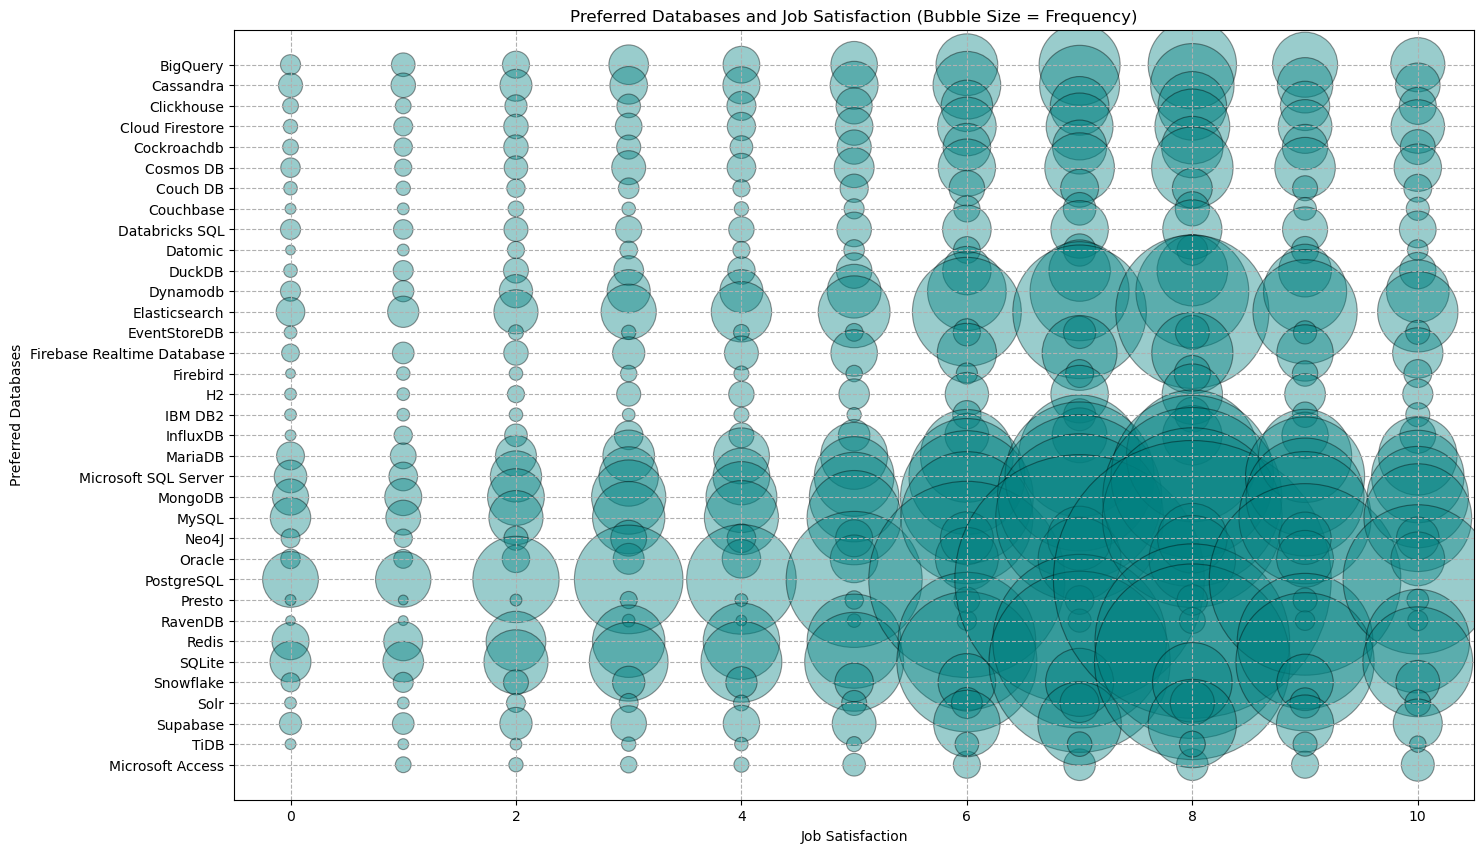

In [11]:
plt.figure(figsize=(16,10))
sns.scatterplot(data=db_sat_group, x="JobSat", y="DatabaseWantToWorkWith", size="Frequency", sizes=(50, 40000), alpha=0.4, legend=False, color='teal', edgecolors='black')
# plt.scatter(data=tech_age_group, x="AgeNumeric", y="LanguageHaveWorkedWith", s="Frequency", alpha=0.4, color='teal', edgecolors='black')
plt.title("Preferred Databases and Job Satisfaction (Bubble Size = Frequency)")
plt.xlabel("Job Satisfaction")
plt.ylabel("Preferred Databases")
plt.grid(True, linestyle='--')

plt.savefig("Lab 20 Plots/Task 2-2 Preferred Databases and Job Satisfaction")
plt.show()

### Task 3: Comparing Data Using Bubble Plots


#### 1. Bubble Plot for Compensation Across Developer Roles

- Visualize compensation (`ConvertedCompYearly`) across different developer roles (`DevType`).

- Use bubble size to represent job satisfaction.


In [12]:
comp_dev_sat = df.copy().loc[:,["DevType", "ConvertedCompYearly", "JobSat"]].dropna()

# comp_dev_sat_group = comp_dev_sat.groupby(['JobSat', 'ConvertedCompYearly']).size().reset_index(name='Frequency')
comp_dev_sat["JobSat"] = comp_dev_sat["JobSat"] * 10
# comp_dev_sat.head(10)

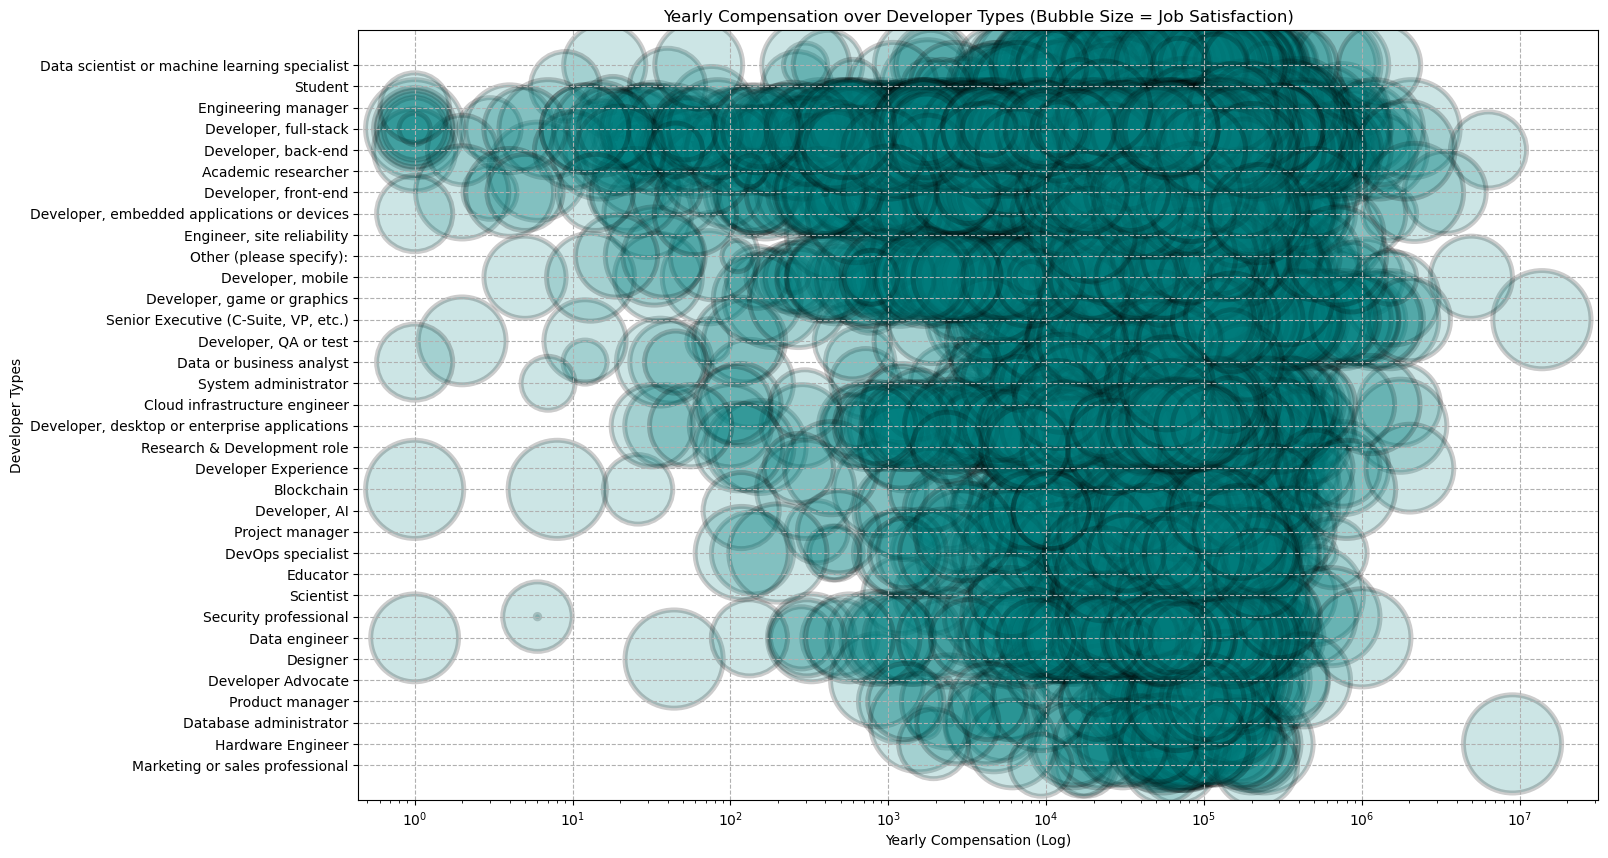

In [13]:
plt.figure(figsize=(16,10))
sns.scatterplot(data=comp_dev_sat, x="ConvertedCompYearly", y="DevType", size="JobSat", sizes=(10, 5000), alpha=0.2, legend=False, color='teal', edgecolors='black')
# plt.scatter(data=tech_age_group, x="AgeNumeric", y="LanguageHaveWorkedWith", s="Frequency", alpha=0.4, color='teal', edgecolors='black')
plt.title("Yearly Compensation over Developer Types (Bubble Size = Job Satisfaction)")
plt.xlabel("Yearly Compensation (Log)")
plt.ylabel("Developer Types")
plt.xscale("log")
plt.grid(True, linestyle='--')

plt.savefig("Lab 20 Plots/Task 3-1 Yearly Compensation over Developer Types")
plt.show()

#### 2. Bubble Plot for Collaboration Tools by Age

- Visualize the relationship between the collaboration tools used (`NEWCollabToolsHaveWorkedWith`) and age groups.

- Use bubble size to represent the frequency of tool usage.


In [17]:
tool_age_freq = df.copy().loc[:, ["NEWCollabToolsHaveWorkedWith", "Age"]].dropna()

tool_age_freq["NEWCollabToolsHaveWorkedWith"] = tool_age_freq["NEWCollabToolsHaveWorkedWith"].str.split(";")
tool_age_freq = tool_age_freq.explode("NEWCollabToolsHaveWorkedWith")
tool_age_freq["NEWCollabToolsHaveWorkedWith"].value_counts()
tool_age_freq_grouped = tool_age_freq.groupby(['NEWCollabToolsHaveWorkedWith', 'Age']).size().reset_index(name='Frequency')
tool_age_freq_grouped["Frequency"] = tool_age_freq_grouped["Frequency"] * 10
tool_age_freq_grouped

NEWCollabToolsHaveWorkedWith                 Age  Frequency
0                      Android Studio     18-24 years old      26630
1                      Android Studio     25-34 years old      34010
2                      Android Studio     35-44 years old      17850
3                      Android Studio     45-54 years old       7110
4                      Android Studio     55-64 years old       2420
5                      Android Studio   65 years or older        650
6                      Android Studio   Prefer not to say        330
7                      Android Studio  Under 18 years old       4790
8                              BBEdit     18-24 years old        350
9                              BBEdit     25-34 years old        840
10                             BBEdit     35-44 years old       1300
11                             BBEdit     45-54 years old       1370
12                             BBEdit     55-64 years old        900
13                             BBEdit   65 years or older        220
14                             BBEdit   Prefer not to say         30
15                             BBEdit  Under 18 years old         50
16                              CLion     18-24 years old      11680
17                              CLion     25-34 years old       7530
18                              CLion     35-44 years old       3340
19                              CLion     45-54 years old       1730
20                              CLion     55-64 years old        750
21                              CLion   65 years or older        130
22                              CLion   Prefer not to say        100
23                              CLion  Under 18 years old       1690
24                       Code::Blocks     18-24 years old       5310
25                       Code::Blocks     25-34 years old       3460
26                       Code::Blocks     35-44 years old       1220
27                       Code::Blocks     45-54 years old        660
28                       Code::Blocks     55-64 years old        270
29                       Code::Blocks   65 years or older        150
30                       Code::Blocks   Prefer not to say        140
31                       Code::Blocks  Under 18 years old       1260
32                           DataGrip     18-24 years old       7090
33                           DataGrip     25-34 years old      11700
34                           DataGrip     35-44 years old       6870
35                           DataGrip     45-54 years old       2600
36                           DataGrip     55-64 years old        630
37                           DataGrip   65 years or older         70
38                           DataGrip   Prefer not to say         50
39                           DataGrip  Under 18 years old        470
40                            Eclipse     18-24 years old      12440
41                            Eclipse     25-34 years old      17780
42                            Eclipse     35-44 years old      11520
43                            Eclipse     45-54 years old       6430
44                            Eclipse     55-64 years old       3400
45                            Eclipse   65 years or older        780
46                            Eclipse   Prefer not to say        300
47                            Eclipse  Under 18 years old       1820
48                              Emacs     18-24 years old       4140
49                              Emacs     25-34 years old       6850
50                              Emacs     35-44 years old       5960
51                              Emacs     45-54 years old       3640
52                              Emacs     55-64 years old       2130
53                              Emacs   65 years or older        720
54                              Emacs   Prefer not to say        130
55                              Emacs  Under 18 years old        890
56                              Fleet     18-24 years old       3130
57     

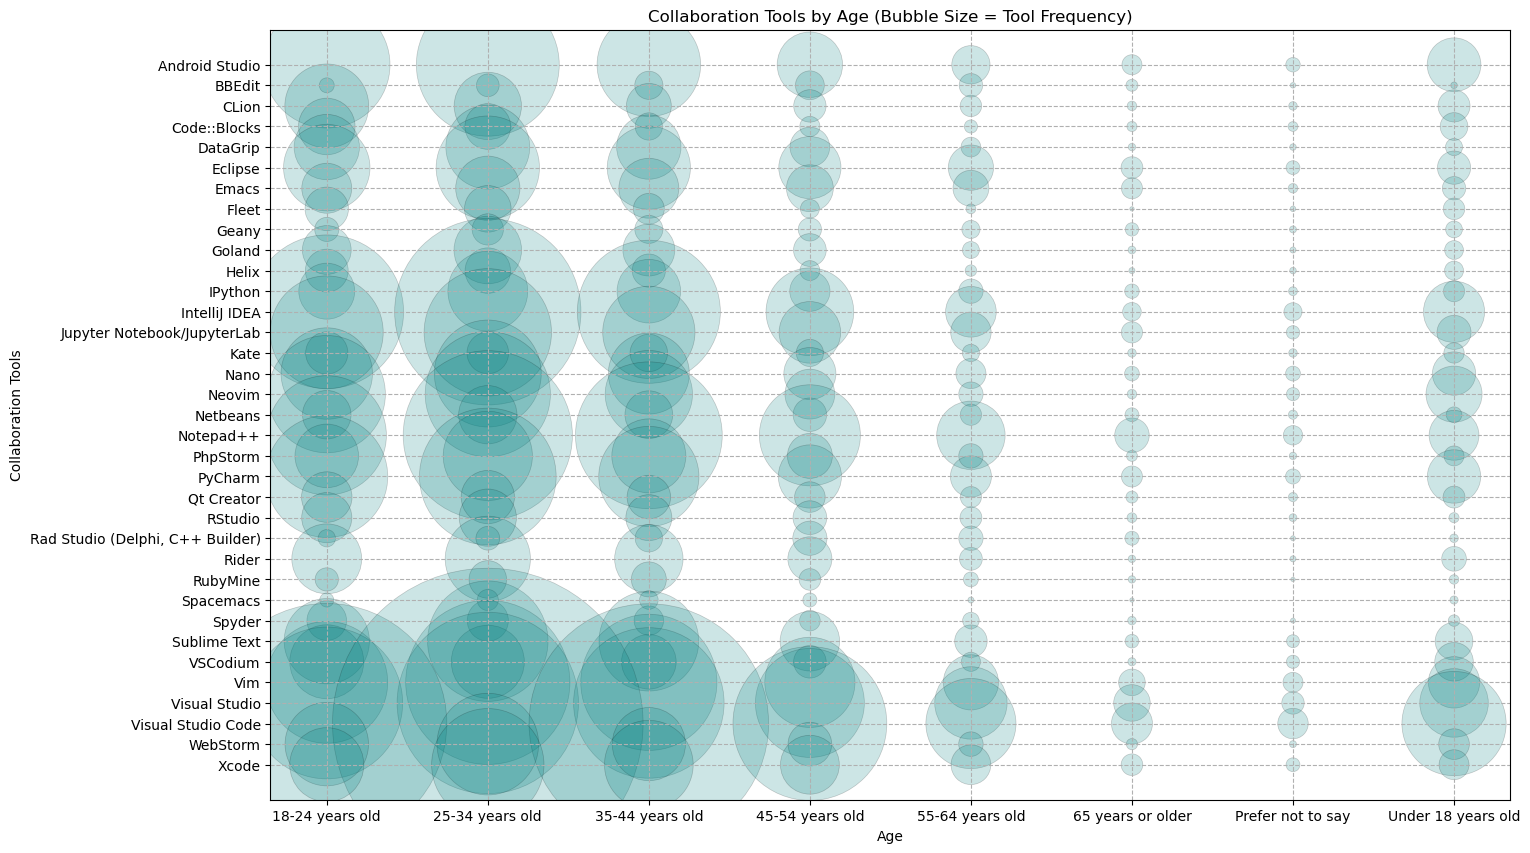

In [22]:
plt.figure(figsize=(16,10))
sns.scatterplot(data=tool_age_freq_grouped, x='Age', y="NEWCollabToolsHaveWorkedWith", size="Frequency", sizes=(10, 50000), alpha=0.2, legend=False, color='teal', edgecolors='black')
# plt.scatter(data=tech_age_group, x="AgeNumeric", y="LanguageHaveWorkedWith", s="Frequency", alpha=0.4, color='teal', edgecolors='black')
plt.title("Collaboration Tools by Age (Bubble Size = Tool Frequency)")
plt.xlabel("Age")
plt.ylabel("Collaboration Tools")
# plt.xscale("log")
plt.grid(True, linestyle='--')

plt.savefig("Lab 20 Plots/Task 3-2 Collaboration Tools by Age")
plt.show()

### Task 4: Visualizing Technology Trends Using Bubble Plots


#### 1. Bubble Plot for Preferred Web Frameworks vs. Job Satisfaction

- Explore the relationship between preferred web frameworks (`WebframeWantToWorkWith`) and job satisfaction.

- Use bubble size to represent the number of respondents.



In [26]:
webframe_sat = df.copy().loc[:, ["WebframeWantToWorkWith", "JobSat"]].dropna()

webframe_sat["WebframeWantToWorkWith"] = webframe_sat["WebframeWantToWorkWith"].str.split(";")
webframe_sat = webframe_sat.explode("WebframeWantToWorkWith")

webframe_sat_group = webframe_sat.groupby(["WebframeWantToWorkWith", "JobSat"]).size().reset_index(name='Frequency')

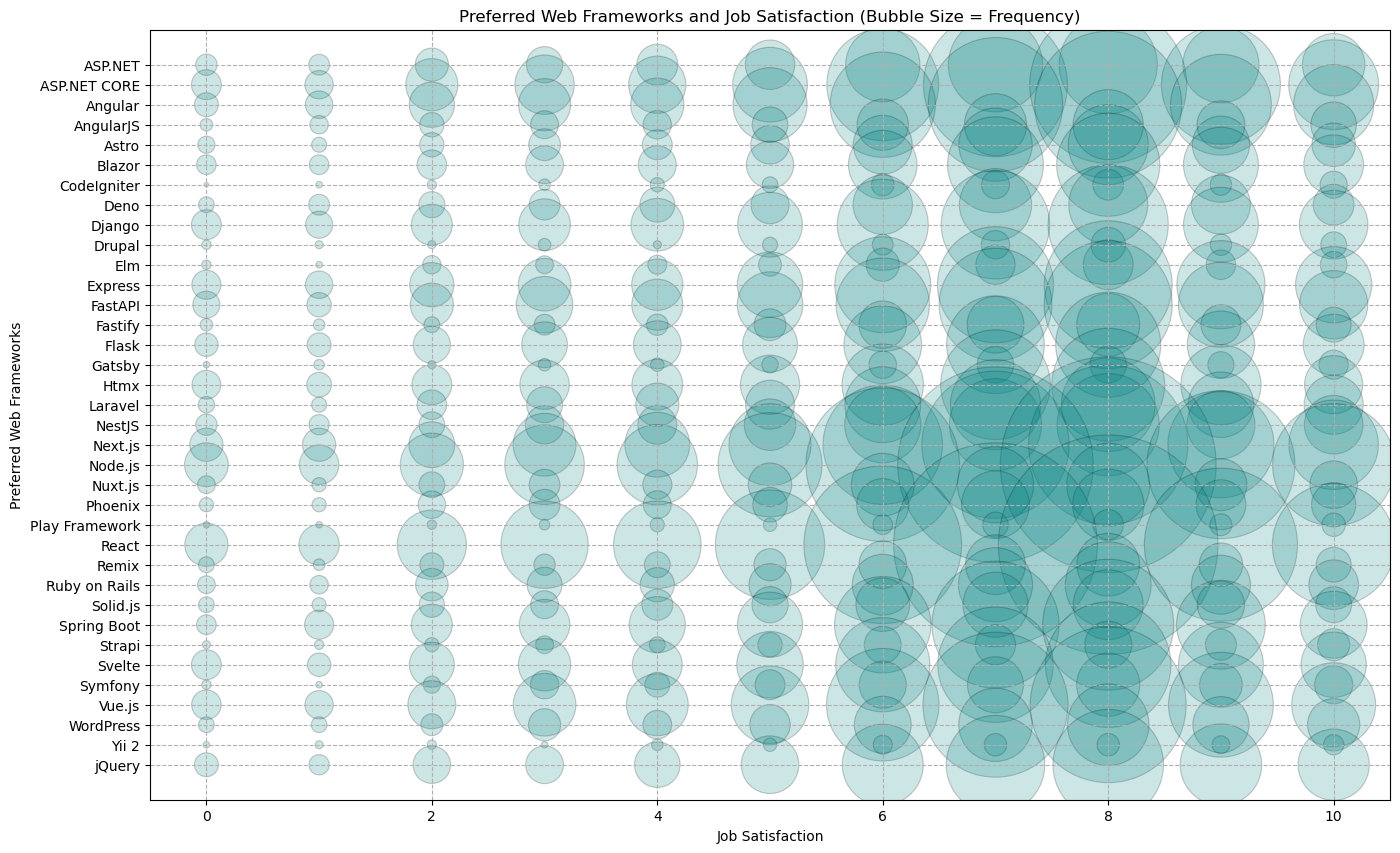

In [29]:
plt.figure(figsize=(16,10))
sns.scatterplot(data=webframe_sat_group, x='JobSat', y="WebframeWantToWorkWith", size="Frequency", sizes=(10, 25000), alpha=0.2, legend=False, color='teal', edgecolors='black')
# plt.scatter(data=tech_age_group, x="AgeNumeric", y="LanguageHaveWorkedWith", s="Frequency", alpha=0.4, color='teal', edgecolors='black')
plt.title("Preferred Web Frameworks and Job Satisfaction (Bubble Size = Frequency)")
plt.xlabel("Job Satisfaction")
plt.ylabel("Preferred Web Frameworks")
# plt.xscale("log")
plt.grid(True, linestyle='--')

plt.savefig("Lab 20 Plots/Task 4-1 Preferred Web Frameworks and Job Satisfaction")
plt.show()

#### 2. Bubble Plot for Admired Technologies Across Countries

- Visualize the distribution of admired technologies (`LanguageAdmired`) across different countries (`Country`).

- Use bubble size to represent the frequency of admiration.



In [32]:
lang_country = df.copy().loc[:, ["LanguageAdmired", "Country"]].dropna()
lang_country.head()
lang_country["LanguageAdmired"] = lang_country["LanguageAdmired"].str.split(";")
lang_country = lang_country.explode("LanguageAdmired")

lang_country_group = lang_country.groupby(["LanguageAdmired", "Country"]).size().reset_index(name='Frequency')

In [40]:
lang_country_group = lang_country_group.loc[lang_country_group["Frequency"] > 50,:]

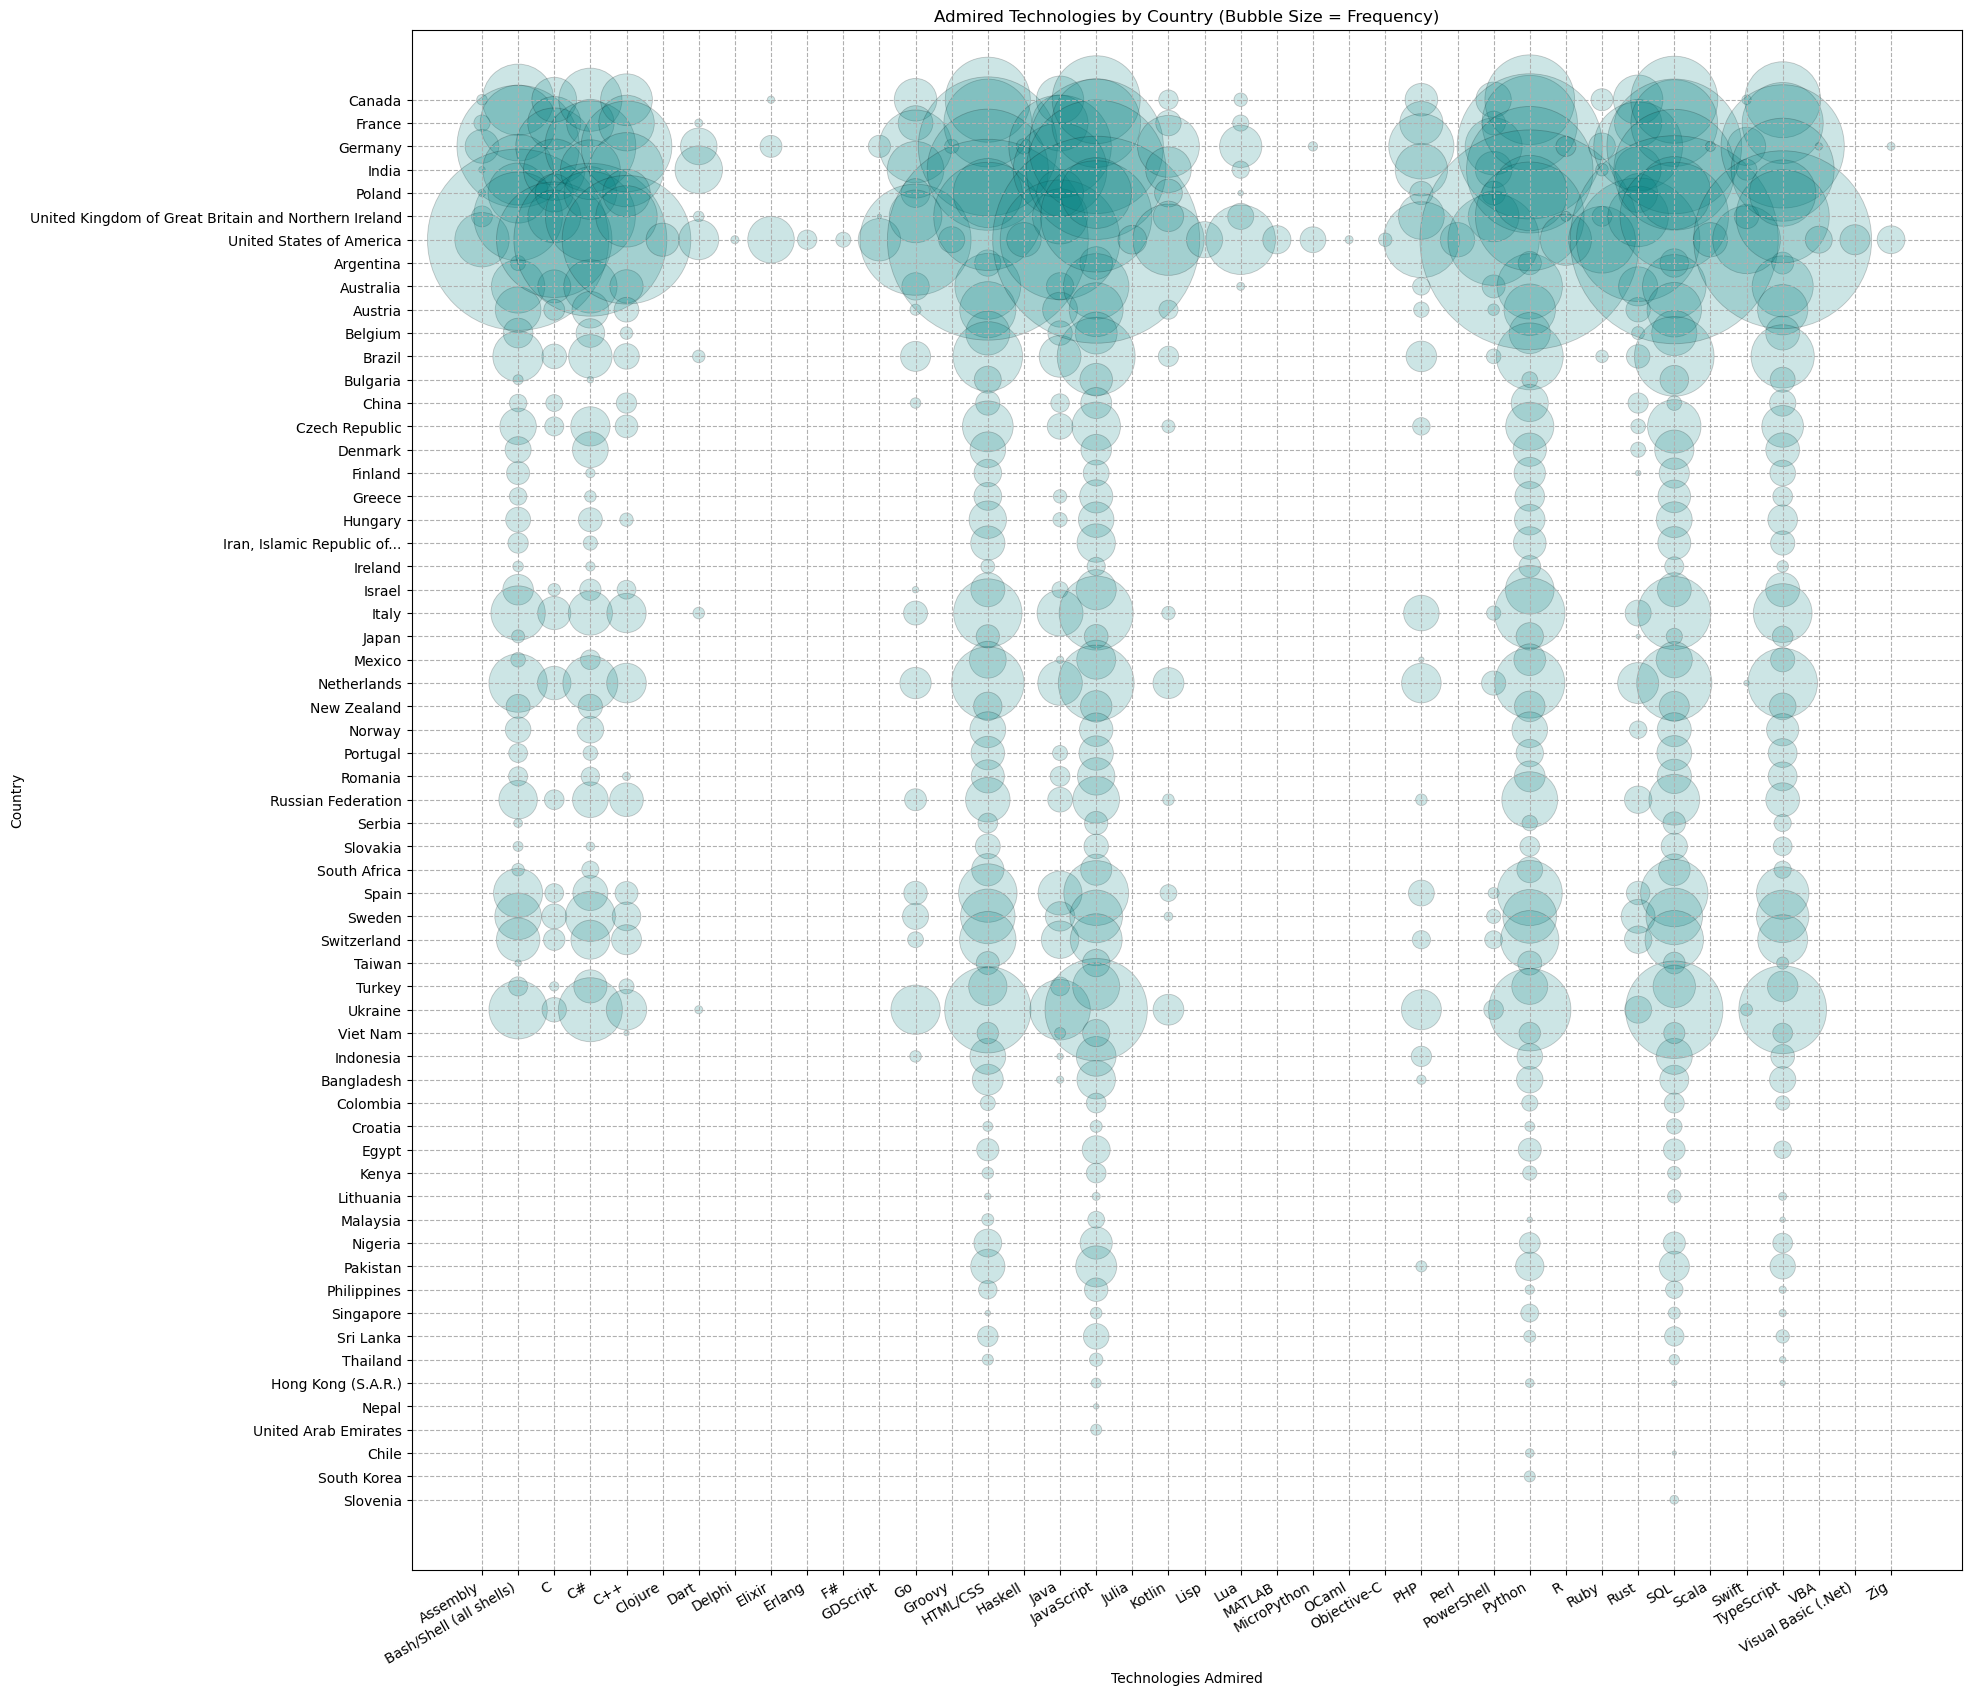

In [42]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=lang_country_group, x='LanguageAdmired', y="Country", size="Frequency", sizes=(10, 25000), alpha=0.2, legend=False, color='teal', edgecolors='black')
# plt.scatter(data=tech_age_group, x="AgeNumeric", y="LanguageHaveWorkedWith", s="Frequency", alpha=0.4, color='teal', edgecolors='black')
plt.title("Admired Technologies by Country (Bubble Size = Frequency)")
plt.xlabel("Technologies Admired")
plt.xticks(rotation=30, ha='right')
plt.ylabel("Country")
# plt.xscale("log")
plt.grid(True, linestyle='--')

plt.savefig("Lab 20 Plots/Task 4-2 Admired Technologies by Country")
plt.show()

## Final Step: Review


After completing the lab, you will have extensively used bubble plots to gain insights into developer community preferences, demographics, compensation trends, and job satisfaction.


## Summary


After completing this lab, you will be able to:

- Create and interpret bubble plots to analyze relationships and compositions within datasets.

- Use bubble plots to explore developer preferences, compensation trends, and satisfaction levels.

- Apply bubble plots to visualize complex relationships involving multiple dimensions effectively.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--
## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2024-10-29|1.2|Madhusudhan Moole|Updated lab|
|2024-10-16|1.1|Madhusudhan Moole|Updated lab|
|2024-10-15|1.0|Raghul Ramesh|Created lab|
--!>


Copyright © IBM Corporation. All rights reserved.
